## Package preparation

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.contrib import rnn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 12})
MARKER_SIZE = 2
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

In [3]:
TIME_STEPS = 168
OUTPUT_SIZE = 1
N_FOLD = 5
N_TASKS = 6

INTERVAL = "1h"

EX_PRED = 0
EXPLANATION_ = "Ion_open_altMT_LN" + "_I" + INTERVAL + "_T" + str(TIME_STEPS)
print(EXPLANATION_)

Ion_open_altMT_LN_I1h_T168


## Data preparation

In [4]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")

In [5]:
ion_label = ion_label[~(ion_label.index < '2018-01-12')]
#ion_label.drop(["N.1"], axis=1, inplace=True)
ion_label.drop(["K", "Ca", "Mg", "S", "N", "P"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
ion_label.dropna(inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-23"), pd.Timestamp("2018-04-12"), pd.Timestamp("2018-04-05")], axis=0, inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-05"), pd.Timestamp("2018-04-13")], axis=0, inplace=True)

In [6]:
ion_label.index += pd.Timedelta("16h")

In [7]:
ion_label = ion_label.sample(frac=1.0)

In [8]:
raw_open = pd.read_csv("./results/open_data.csv", index_col="TIMESTAMP")
raw_open.index = pd.DatetimeIndex(raw_open.index)
raw_open = raw_open[np.abs(raw_open-raw_open.mean())<=(3*raw_open.std())]
raw_open["RootTemp(2)"][0] = 20
raw_open.drop(["ECS(4)", "InjDrgVR(4)", "DrgDaily(4)", "DrgV(4)"], axis=1, inplace=True)
#raw_open.drop(["MixTnkpH(4)", "RWEC(4)", "InjDrgVR(4)", "DrgDaily(4)"], axis=1, inplace=True)

In [9]:
raw_open.interpolate("linear", inplace=True)

# raw_open.index = (raw_open.index).round(INTERVAL)
# raw_open = raw_open.groupby(raw_open.index).mean()

In [10]:
MAXS = raw_open.max()
MINS = raw_open.min()
LABELMAXS = ion_label.max()
LABELMINS = ion_label.min()

In [11]:
raw_open = (raw_open - MINS) / (MAXS - MINS)
ion_label = (ion_label - LABELMINS) / (LABELMAXS - LABELMINS)

In [12]:
env_input = []
for index in ion_label.index:
    last_time = index
    first_time = last_time - pd.Timedelta(INTERVAL)*(TIME_STEPS-1)
    
    TRAIN_RANGE = pd.date_range(first_time, last_time, freq=INTERVAL)
    env_input.append(raw_open.loc[TRAIN_RANGE])

In [13]:
for i in range(len(env_input)):
    env_input[i] = env_input[i].values
    
env_input = np.array(env_input)

In [14]:
env_input.shape

(52, 168, 23)

In [15]:
rnn_inputs = []
rnn_labels = []
pred_inputs = []
pred_labels = []

N_TEST = int(ion_label.shape[0]/N_FOLD)

for i in range(N_FOLD-1):
    pred_inputs.append(env_input[i*N_TEST:(i+1)*N_TEST, :, :])
    pred_labels.append(ion_label.iloc[i*N_TEST:(i+1)*N_TEST, :])
    
    rnn_inputs.append(np.delete(env_input, np.arange(i*N_TEST, (i+1)*N_TEST), 0))
    rnn_labels.append(ion_label.drop(ion_label.index[np.arange(i*N_TEST, (i+1)*N_TEST)], axis=0))



pred_inputs.append(env_input[(N_FOLD-1)*N_TEST:, :, :])
pred_labels.append(ion_label.iloc[(N_FOLD-1)*N_TEST:, :])

rnn_inputs.append(env_input[:(N_FOLD-1)*N_TEST:, :, :])
rnn_labels.append(ion_label.iloc[:(N_FOLD-1)*N_TEST:, :])

In [16]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Network

In [17]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')

1 fold start.
Epoch:        0/   50000 cost: 7.473798, best: 0.000
Training Acc: -2.101, Test Acc: -1.932
-0.077 -0.166 -4.802 -2.930 0.194 -1.225 
-1.5012379390450932
Epoch:      500/   50000 cost: 0.027502, best: 0.000
Training Acc: 0.848, Test Acc: -1.746
-9.454 -4.486 -0.753 -2.474 -1.769 0.010 
-3.154210752019022
Epoch:     1000/   50000 cost: 0.020533, best: 0.000
Training Acc: 0.850, Test Acc: -0.863
-6.545 -3.611 -0.121 -0.670 -1.186 0.235 
-1.9829697733660412
Epoch:     1005/   50000 cost: 0.016291, best: 0.031 *Best value was replaced.
-2.116 -1.658 0.213 0.206 0.216 0.448 
-0.4483909552796325
Epoch:     1006/   50000 cost: 0.008962, best: 0.413 *Best value was replaced.
-0.575 -0.537 0.391 0.549 0.635 0.614 
0.17960148362581732
Epoch:     1039/   50000 cost: 0.011977, best: 0.421 *Best value was replaced.
-0.449 -0.864 0.560 0.491 0.140 0.772 
0.10846985971045926
Epoch:     1040/   50000 cost: 0.037480, best: 0.622 *Best value was replaced.
0.024 -0.087 0.641 0.668 0.552 0.8

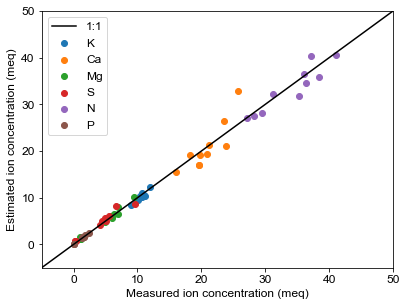

6 fold ended.
2 fold start.
Epoch:        0/   50000 cost: 7.084091, best: 0.000
Training Acc: -2.066, Test Acc: -1.328
-0.214 -0.270 -3.836 -1.445 -1.078 -3.143 
-1.6644859446672402
Epoch:      500/   50000 cost: 0.011513, best: 0.000
Training Acc: 0.712, Test Acc: 0.641
0.334 0.614 0.645 0.698 0.669 0.764 
0.6206340505714688
Epoch:     1000/   50000 cost: 0.005562, best: 0.000
Training Acc: 0.675, Test Acc: 0.249
0.064 -0.140 0.356 0.253 0.263 0.454 
0.20844571536576176
Epoch:     1002/   50000 cost: 0.007018, best: 0.366 *Best value was replaced.
0.172 0.169 0.378 0.318 0.414 0.495 
0.32442846481475024
Epoch:     1003/   50000 cost: 0.014066, best: 0.440 *Best value was replaced.
0.235 0.375 0.382 0.336 0.543 0.498 
0.3947700528741119
Epoch:     1004/   50000 cost: 0.012107, best: 0.529 *Best value was replaced.
0.383 0.605 0.394 0.283 0.694 0.520 
0.48008821688001774
Epoch:     1005/   50000 cost: 0.006642, best: 0.552 *Best value was replaced.
0.526 0.671 0.359 0.219 0.728 0.480 


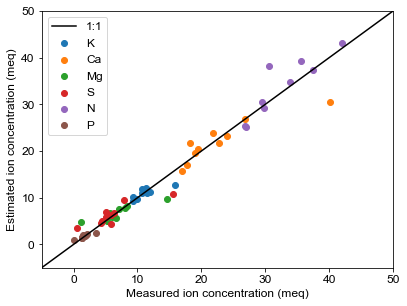

6 fold ended.
3 fold start.
Epoch:        0/   50000 cost: 10.537665, best: 0.000
Training Acc: -3.719, Test Acc: -7.287
-4.183 -11.637 -10.102 -0.005 -8.420 -15.743 
-8.3482630241089
Epoch:      500/   50000 cost: 0.018718, best: 0.000
Training Acc: 0.887, Test Acc: 0.534
0.400 0.161 0.849 0.457 0.427 0.453 
0.45790681086994817
Epoch:     1000/   50000 cost: 0.005270, best: 0.000
Training Acc: 0.769, Test Acc: 0.488
-0.041 0.063 0.822 0.510 0.304 0.816 
0.41233878772468674
Epoch:     1002/   50000 cost: 0.008675, best: 0.508 *Best value was replaced.
-0.037 0.115 0.831 0.586 0.316 0.825 
0.43932212790700637
Epoch:     1003/   50000 cost: 0.006081, best: 0.560 *Best value was replaced.
0.140 0.133 0.868 0.697 0.356 0.821 
0.5025478656577844
Epoch:     1004/   50000 cost: 0.015170, best: 0.572 *Best value was replaced.
0.236 0.083 0.862 0.658 0.368 0.864 
0.5120009599277129
Epoch:     1010/   50000 cost: 0.005782, best: 0.604 *Best value was replaced.
0.418 -0.010 0.876 0.629 0.534 0.79

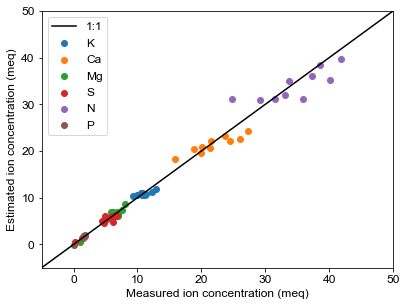

6 fold ended.
4 fold start.
Epoch:        0/   50000 cost: 5.279800, best: 0.000
Training Acc: -2.356, Test Acc: -4.249
-1.492 -2.779 -126.684 -63.869 -4.636 -205.177 
-67.43944814443707
Epoch:      500/   50000 cost: 0.027927, best: 0.000
Training Acc: 0.769, Test Acc: 0.841
0.009 0.076 -0.091 -0.711 0.164 -0.552 
-0.18401932182563954
Epoch:     1000/   50000 cost: 0.005046, best: 0.000
Training Acc: 0.870, Test Acc: 0.726
-2.387 0.343 -0.532 -4.914 0.451 -1.092 
-1.3549837578292327
Epoch:     1002/   50000 cost: 0.007235, best: 0.792 *Best value was replaced.
-1.192 0.231 -0.296 -3.078 0.459 -0.711 
-0.764678696495548
Epoch:     1003/   50000 cost: 0.005355, best: 0.824 *Best value was replaced.
-0.688 0.070 0.189 -1.311 0.394 -0.487 
-0.3056005380118857
Epoch:     1165/   50000 cost: 0.008923, best: 0.833 *Best value was replaced.
-0.509 0.255 -0.465 -0.938 0.302 0.137 
-0.20290358757897983
Epoch:     1266/   50000 cost: 0.007800, best: 0.837 *Best value was replaced.
-0.948 0.434 0

In [ ]:
accuracies = []
for i in range(N_FOLD):
    print("%d fold start." % (i+1))

    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]
    
    # Parameters
    EXPLANATION = EXPLANATION_+ "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 1000

    global_step = tf.Variable(0, trainable=False)    
    LEARNING_RATE = tf.train.exponential_decay(0.03, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.0001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 64
    N_FC_HIDDEN = 64
    DROP_PROB = 0.9
    BATCH_SIZE = 16
    DISPLAY_STEP = 500
    N_INPUT = env_input[0].shape[1]
    N_OUTPUT = ion_label.shape[1]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable("F"+ str(i+1) + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("F"+ str(i+1) + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)

    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)
        
        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation
    

    def Task_specific_FC(x, n_hidden, phase, tasknum):
        h1 = BN_FC(x, n_hidden, phase, "task" + str(tasknum) + "_layer1")
        h2 = BN_FC(h1, n_hidden, phase, "task" + str(tasknum) + "_layer2")
        
        return FC(h2, 1, "task" + str(tasknum) + "_out")


    # Construct model
    shared_layer = RNN(x, weights, biases, drop_prob)
    pred_1 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 1)
    pred_2 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 2)
    pred_3 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 3)
    pred_4 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 4)
    pred_5 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 5)
    pred_6 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 6)
    pred = tf.concat([pred_1, pred_2, pred_3, pred_4, pred_5, pred_6], axis=1)


    # Define loss and optimizer
    #cost = tf.reduce_sum(tf.square(tf.subtract(pred, y)))
    cost_1 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 0], [-1, 1]), predictions=pred_1)
    cost_2 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 1], [-1, 1]), predictions=pred_2)
    cost_3 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 2], [-1, 1]), predictions=pred_3)
    cost_4 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 3], [-1, 1]), predictions=pred_4)
    cost_5 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 4], [-1, 1]), predictions=pred_5)
    cost_6 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 5], [-1, 1]), predictions=pred_6)
    joint_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5 + cost_6
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        #optimizer = optimizer_.minimize(joint_cost, global_step=global_step)
        op1 = optimizer_.minimize(cost_1, global_step=global_step)
        op2 = optimizer_.minimize(cost_2, global_step=global_step)
        op3 = optimizer_.minimize(cost_3, global_step=global_step)
        op4 = optimizer_.minimize(cost_4, global_step=global_step)
        op5 = optimizer_.minimize(cost_5, global_step=global_step)
        op6 = optimizer_.minimize(cost_6, global_step=global_step)
    tf.summary.scalar('cost', joint_cost)

    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    R_squared = tf.subtract(1., tf.divide(unexplained_error, total_error))
    
    accuracy = R_squared
    tf.summary.scalar('accuracy', accuracy)

    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()
        
    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/open_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/open_" + "F"+ str(i+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    ex_pred_acc = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()
       
    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, = sess.run([joint_cost, merged], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        
        op_set = [sess.run(op1, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op2, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op3, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op4, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op5, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op6, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})]
        op_selector = int((N_TASKS)*np.random.rand())
        op_set[op_selector]
        
        train_writer.add_summary(summary, EPOCH)
        R2, summary, pred_acc = sess.run([pred, merged, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        test_writer.add_summary(summary, EPOCH)
        
        if pred_acc > ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc > best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
                for i in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label.iloc[:,i], R2[:,i]), end=" ")
                print("")
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for __ in range(N_TASKS):
                print("%.3f"% r2_score(pred_label.iloc[:,__], R2[:,__]), end=" ")
            print("")
            print(r2_score(pred_label, R2))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))

    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)

    print ("Test accuracy:", final_acc)

    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    prediction = (prediction * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_label = (pred_label * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_df = pd.DataFrame(prediction)
    pred_df.index = pred_label.index
    pred_df.columns = ["K", "Ca", "Mg", "S", "N", "P"]

    ion_results = pd.concat([pred_label, pred_df], axis = 1)
    ion_results.to_csv("./results/results_" + EXPLANATION + ".csv")

    x_linear = np.arange(min(ion_results.min()) - 5, max(ion_results.max()) + 15)
    y_linear = x_linear


    linear = plt.plot(x_linear, y_linear, "k-")
    for _ in range(6):
        scatter = plt.scatter(ion_results.iloc[:, _], ion_results.iloc[:, _+6])

    plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
    plt.xlabel("Measured ion concentration (meq)")
    plt.ylabel("Estimated ion concentration (meq)")
    plt.axis([-5, 50, -5, 50])
    plt.show()
    print("%d fold ended." % (i+1))
    tf.reset_default_graph()
    sess.close()

print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))